In [2]:
import sqlite3 as sq
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal

In [3]:
con = sq.connect('../CP.db')

In [35]:
status_lu = pd.read_sql('SELECT * FROM instruments_lu WHERE(shortname="status")', con)
status_tables = list(status_lu.instr_table)
status_lu

,shortname,instr_model,site,height,rep,instr_sn,logger_sn,instr_table,comment
0,status,CR3000,NF,0.0,1,9809,9809,status_NF_0cm_1,NF EC 17m logger
1,status,CR1000X,NF,0.0,2,23311,23311,status_NF_0cm_2,NF Burba 17m logger
2,status,CR3000,NF,0.0,3,10365,10365,status_NF_0cm_3,NF EC 3m logger
3,status,CR1000,NF,0.0,4,3863,3863,status_NF_0cm_4,NF3 sap logger
4,status,CR1000,NF,0.0,5,3860,3860,status_NF_0cm_5,first snow logger at NF
5,status,CR1000,NF,0.0,6,3864,3864,status_NF_0cm_6,NF soils logger


## Plot Voltage Data and highlight duplicates

In [37]:
table_name = status_lu.instr_table[0]
status1 = pd.read_sql(f'SELECT * FROM {table_name} WHERE(stat="avg")', con, parse_dates=['timestamp']).replace(['NAN'], [np.nan]).sort_values('timestamp')
# sort by timestamp
status1 = status1.replace(['NAN'], [np.nan]).sort_values('timestamp')

In [42]:
status1.duplicated(subset='timestamp', keep=False)

2223      True
2241      True
2242      True
2224      True
2243      True
         ...  
50747    False
50748    False
50749    False
50750    False
50751    False
Length: 52640, dtype: bool

In [43]:
status1 = status1.replace(['NAN'], [np.nan]).sort_values('timestamp')
status1[~status1.duplicated(subset='timestamp', keep=False)]

,idx,timestamp,stat,vlogger_1_1_1,tlogger_1_1_1
2259,2189,2019-04-25 19:00:00,avg,12.11861,7.472826
2260,2190,2019-04-25 19:30:00,avg,12.10152,6.774170
2261,2191,2019-04-25 20:00:00,avg,12.08743,5.857154
2262,2192,2019-04-25 20:30:00,avg,12.07239,4.762282
2263,2193,2019-04-25 21:00:00,avg,12.05770,3.619309
...,...,...,...,...,...
50747,50677,2022-07-15 09:00:00,avg,NaN,NaN
50748,50678,2022-07-15 09:30:00,avg,NaN,NaN
50749,50679,2022-07-15 10:00:00,avg,NaN,NaN
50750,50680,2022-07-15 10:30:00,avg,NaN,NaN


In [34]:
status1 = status1.replace(['NAN'], [np.nan]).sort_values('timestamp')

# indices of duplicated entries
dupe_indices = status1.drop(columns=['idx', 'stat']).duplicated(keep=False)

# keep non-duplicated entries
status1 = status1[~dupe_indices]


Text(2021-06-08 00:00:00, 18, 'Set NF17 clock back 1hr, 2021-06-08')

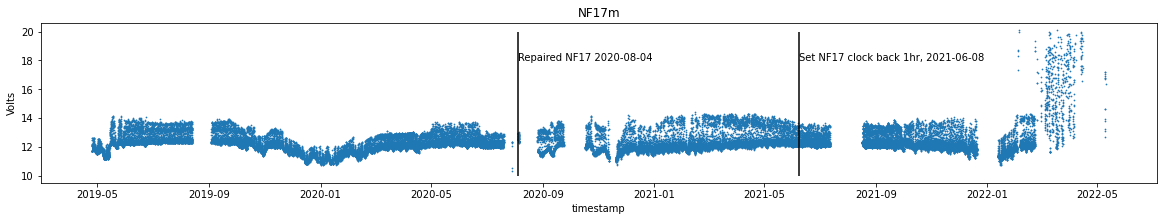

In [14]:
table_name = status_lu.instr_table[0]
status1 = pd.read_sql(f'SELECT * FROM {table_name} WHERE(stat="avg")', con, parse_dates=['timestamp']).replace(['NAN'], [np.nan]).sort_values('timestamp')
table_name = status_lu.instr_table[2]
status2 = pd.read_sql(f'SELECT * FROM {table_name} WHERE(stat="avg")', con, parse_dates=['timestamp']).replace(['NAN'], [np.nan]).sort_values('timestamp')

duplicate_ts1 = status1[status1.duplicated(subset=['timestamp'], keep=False)]
duplicate_ts1_2 = status1[status1.duplicated()]
# duplicate_ts2 = status2[~status2.duplicated(subset=['timestamp'], keep=False)]

fig = plt.figure(figsize=(20,10))

ax = fig.add_subplot(3,1,1)
plt.title('NF17m')
status1.plot('timestamp', 'vlogger_1_1_1', kind='scatter', s=0.5, ax = ax)
# duplicate_ts1.plot('timestamp', 'vlogger_1_1_1', kind='scatter', color='red', ax=ax, s=3)
duplicate_ts1_2.plot('timestamp', 'vlogger_1_1_1', kind='scatter', color='green', ax=ax, s=4)
plt.ylabel('Volts')

plt.vlines(pd.to_datetime('2020-08-04'), 10, 20, color='k')
plt.text(pd.to_datetime('2020-08-04'), 18, 'Repaired NF17 2020-08-04', fontsize=10)
plt.vlines(pd.to_datetime('2021-06-08'), 10, 20, color='k')
plt.text(pd.to_datetime('2021-06-08'), 18, 'Set NF17 clock back 1hr, 2021-06-08', fontsize=10)


# ax = fig.add_subplot(3,1,3)
# plt.title('NF3m')
# status2.plot('timestamp', 'vlogger_2_1_1', kind='scatter', s=0.5, ax = ax)
# duplicate_ts2.plot('timestamp', 'vlogger_2_1_1', kind='scatter', color='red', ax=ax, s=3, label='Duplicates')
# plt.ylabel('Volts')

# plt.legend();



In [148]:
time_array = pd.DataFrame(pd.date_range('2019-01-01 00:00:00', '2022-03-01 00:00:00', freq='30 min'), columns=['timestamp']).set_index('timestamp').sort_values('timestamp')

In [155]:
ec_status = ec3_status.set_index('timestamp').join(ec17_status.set_index('timestamp'), lsuffix='2_1_1', rsuffix='1_1_1', how='outer')
ec_status = ec_status.join(time_array, how='right').sort_values('timestamp')

## Break up data into continuous runs without any NANs

In [159]:
# find indices for nans without repeats
nans = np.array(sorted(list(set(list(np.where(np.isnan(ec_status[['tlogger_1_1_1']]))[0]) + list(np.where(np.isnan(ec_status[['tlogger_2_1_1']]))[0])))))
# find gaps between nans
gapsizes = np.diff(nans)
# where gaps are greater than one, there is a continuous run of data
where_nan_runs_end = np.where(gapsizes - 1)
# find the length of this run
data_length = gapsizes[where_nan_runs_end] - 1
# start of this run of data and where it ends
data_start = nans[where_nan_runs_end] + 1
next_nan = data_start + data_length 

In [168]:
ec_status

,idx2_1_1,stat2_1_1,vlogger_2_1_1,tlogger_2_1_1,idx1_1_1,stat1_1_1,vlogger_1_1_1,tlogger_1_1_1
timestamp,,,,,,,,
2019-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-01 00:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-01 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-01 01:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-01 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2022-02-28 22:00:00,50525.0,avg,12.07359,-1.851012,44661.0,avg,NaN,18.497590
2022-02-28 22:30:00,50526.0,avg,12.06489,-2.185365,44662.0,avg,15.88050,17.113060
2022-02-28 23:00:00,50527.0,avg,12.05772,-2.397401,44663.0,avg,14.90384,12.403940


In [157]:
def standardize(x):
    return (x - x.mean())/x.std()

## Compute the cross-correlation between logger voltages at EC3m and at EC17m loggers and identify phase shifts
Do this for each sizeable run of continuous data

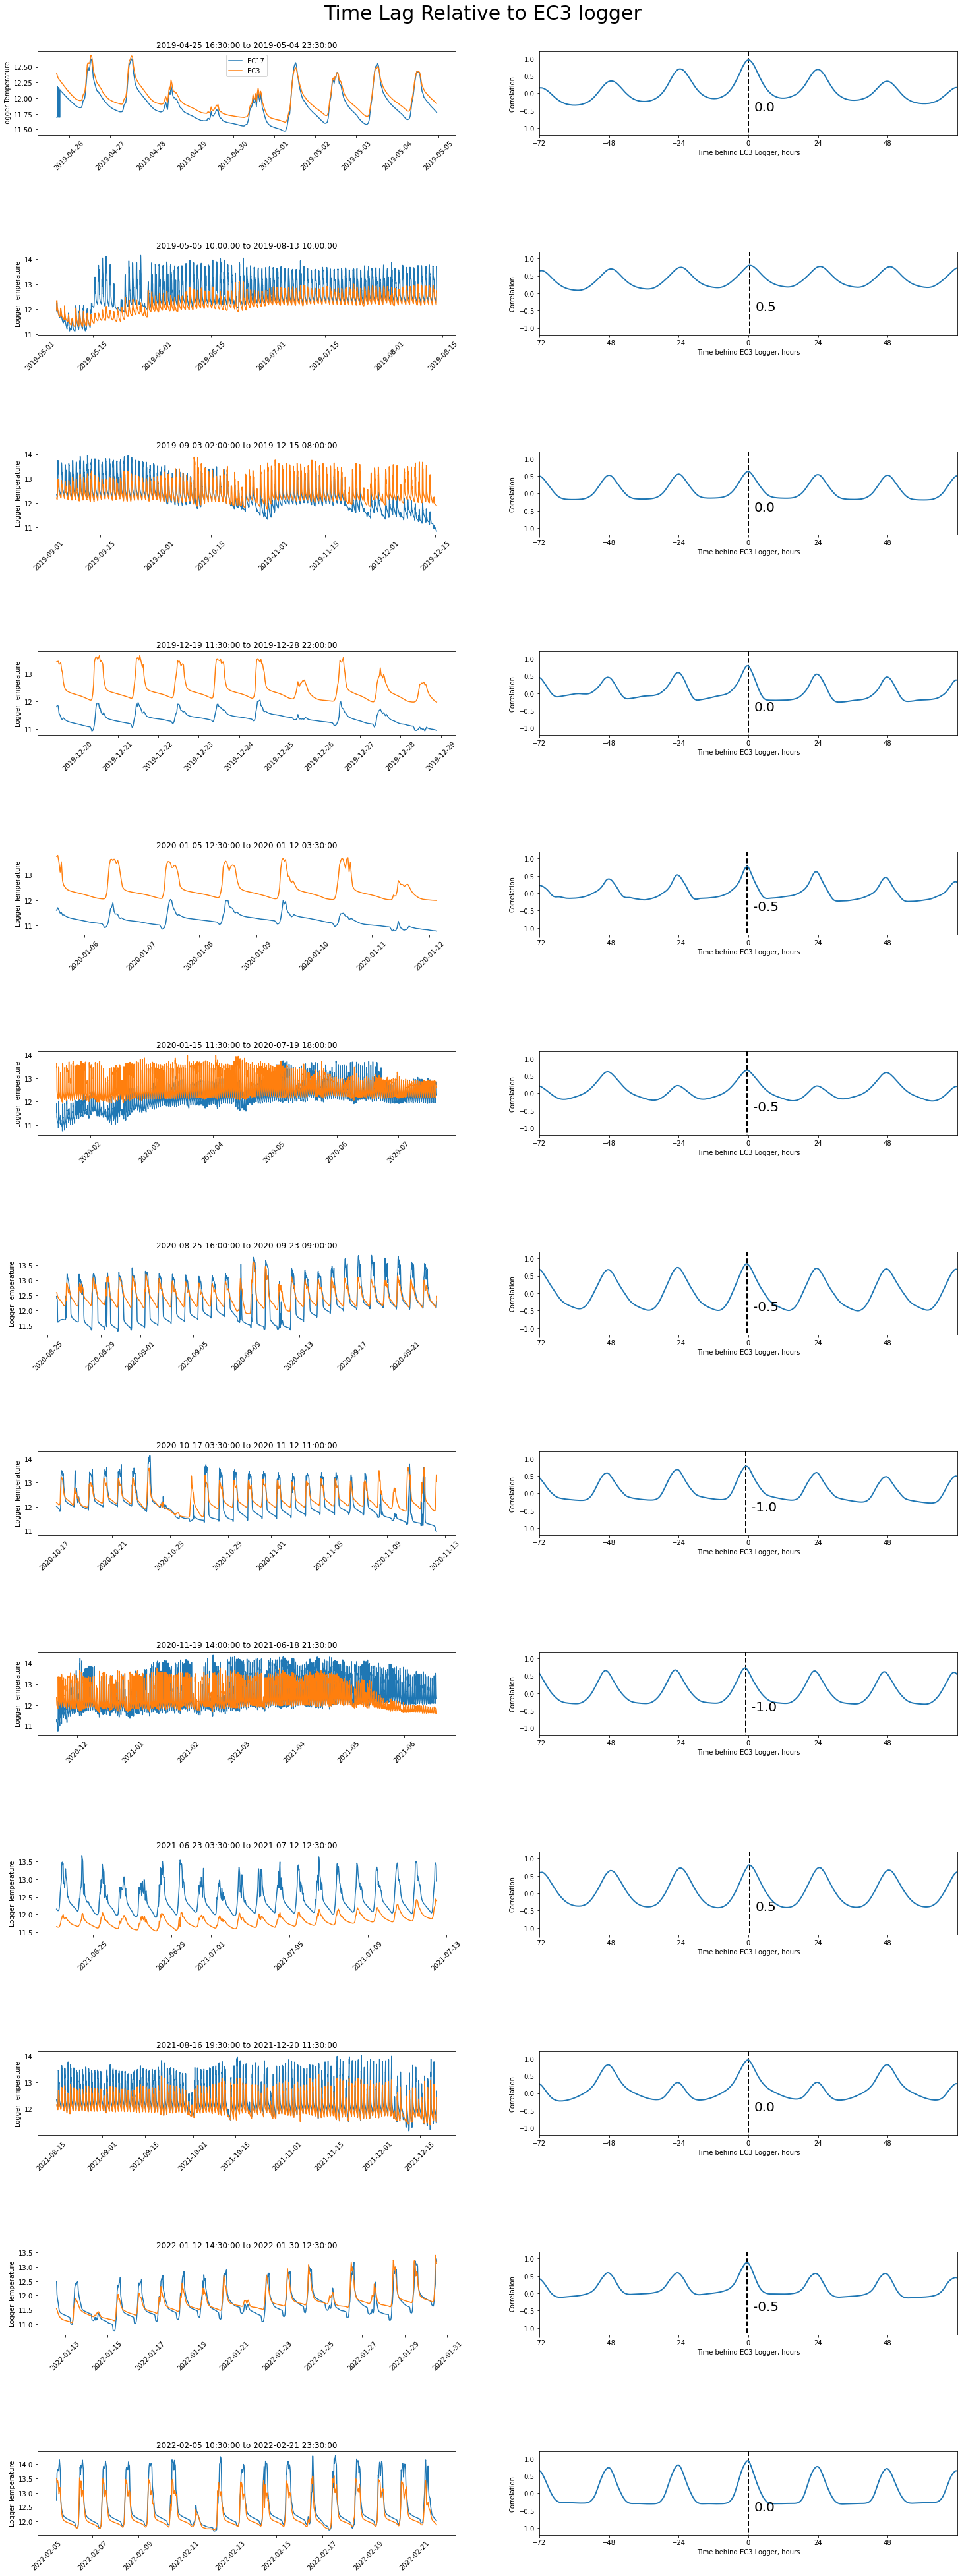

In [169]:
fig = plt.figure(figsize=(25,100))
fig.suptitle('Time Lag Relative to EC3 logger', y=0.89, fontsize=30)
plt.tight_layout()
i=0
for start, end in zip(data_start, next_nan):
    if end - start > 48*4:
#         print(ec_status[start:end].reset_index().duplicated(subset=['timestamp']).sum())
        fig.add_subplot(36,2,i+1)
        size = len(ec_status.vlogger_1_1_1[start:end])
        t = np.arange(0, size, 1)/2  # hours
        plt.plot(ec_status.vlogger_1_1_1[start:end], label='EC17')
        plt.plot(ec_status.vlogger_2_1_1[start:end], label='EC3')
        plt.xticks(rotation=45)
        plt.ylabel('Logger Voltage')
        
        plt.title(f'{ec_status.index[start]} to {ec_status.index[end]}')
        
        if i==0: plt.legend()

        lags = signal.correlation_lags(size, size)/2
        corr = signal.correlate(standardize(ec_status.vlogger_2_1_1[start:end]), standardize(ec_status.vlogger_1_1_1[start:end]))
        fig.add_subplot(36,2,i+2)
        plt.plot(lags, corr/size, lw=2)
        plt.ylabel('Correlation')
        plt.xlabel('Time behind EC3 Logger, hours')
       
        lag = lags[np.argmax(corr)]
        plt.vlines(lag, -10, 10, lw=2, linestyle='--', color='k')
        plt.text(lag + 2, -0.5, lag, fontsize=20)
        plt.ylim(-1.2, 1.2)
        plt.xlim(-72, 72)   
        plt.xticks(np.arange(-72, 72, 24))
        
        i += 4